In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms
from PIL import Image

import os
import csv
import numpy as np
import glob
import random

from sklearn.metrics import accuracy_score, f1_score

## Load Data

In [2]:
def search_in_labels(filename, label_dict):
    base_name = os.path.splitext(filename)[0]
    
    if "_logmel" in base_name:
        base_name = base_name.replace("_logmel", "")
    if "_flipped" in base_name:
        base_name = base_name.replace("_flipped", "")
    
    parts = base_name.split("_")
    if len(parts) >= 2:
        audio_filename = f"{parts[0]}_{parts[1]}.wav"
    else:
        audio_filename = f"{base_name}.wav"
    
    return label_dict.get(audio_filename, None)

In [3]:
class ContrastiveEmbeddingExtractor(nn.Module):
    def __init__(self, input_dim=3072, projection_dim=256, hidden_dim=512):
        super(ContrastiveEmbeddingExtractor, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        self.projection_head = nn.Sequential(
            nn.Linear(hidden_dim, projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim),
            L2Norm(dim=1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
    
    def forward(self, x, return_features=False):
        features = self.encoder(x)
        
        logits = self.classifier(features)
        
        if return_features:
            projections = self.projection_head(features)
            return logits.squeeze(), projections, features
        else:
            return logits.squeeze()

class L2Norm(nn.Module):
    def __init__(self, dim=1):
        super(L2Norm, self).__init__()
        self.dim = dim
    
    def forward(self, x):
        return F.normalize(x, p=2, dim=self.dim)
    
class SupervisedContrastiveLoss(nn.Module):

    def __init__(self, temperature=0.1, minority_weight=2.0):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.minority_weight = minority_weight
        
    def forward(self, projections, labels):
        device = projections.device
        batch_size = projections.shape[0]
        
        similarity_matrix = torch.matmul(projections, projections.T) / self.temperature
        
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(device)
        
        mask = mask - torch.eye(batch_size).to(device)
        
        exp_sim = torch.exp(similarity_matrix)
        
        pos_sim = exp_sim * mask
        
        neg_mask = torch.ones_like(mask) - torch.eye(batch_size).to(device)
        all_sim = exp_sim * neg_mask
        
        losses = []
        for i in range(batch_size):
            if mask[i].sum() > 0:  
                pos_sum = pos_sim[i].sum()
                neg_sum = all_sim[i].sum()
                
                if neg_sum > 0:
                    loss_i = -torch.log(pos_sum / neg_sum)
                    
                    if labels[i] == 1:  
                        loss_i = loss_i * self.minority_weight
                    
                    losses.append(loss_i)
        
        if len(losses) > 0:
            return torch.stack(losses).mean()
        else:
            return torch.tensor(0.0).to(device)

class CombinedLoss(nn.Module):
    def __init__(self, classification_loss, contrastive_loss, alpha=0.3):
        super(CombinedLoss, self).__init__()
        self.classification_loss = classification_loss
        self.contrastive_loss = contrastive_loss
        self.alpha = alpha  
        
    def forward(self, logits, projections, labels):
        cls_loss = self.classification_loss(logits, labels.float())
        
        cont_loss = self.contrastive_loss(projections, labels)
        
        total_loss = (1 - self.alpha) * cls_loss + self.alpha * cont_loss
        
        return total_loss, cls_loss, cont_loss

In [4]:
label_dict = {}
with open("../ComParE2017_Cold_4students/lab/ComParE2017_Cold.tsv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    rows = list(reader)
    for row in tqdm(rows, desc="Loading labels"):
        label_dict[row["file_name"]] = row["Cold (upper respiratory tract infection)"]

Loading labels: 100%|██████████| 19101/19101 [00:00<00:00, 3449235.83it/s]


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load weights from the pretrained model
model = ContrastiveEmbeddingExtractor(input_dim=3072, projection_dim=256, hidden_dim=512).to(device)
pretrained_model_path = "../best_contrastive_embedding_model.pth"
model.load_state_dict(torch.load(pretrained_model_path))
model

ContrastiveEmbeddingExtractor(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
  )
  (projection_head): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): L2Norm()
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [8]:
class ColdDetectionDataset(Dataset):
    def __init__(self,
                 embedding_dict: dict,
                 label_dict: dict,
                 label_ratio = 2,
                ):
        
        self.data_map = {} 
        self.all_samples = []
        
        for file_id, emb in embedding_dict.items():
            label_key = f"{file_id}.wav"
            if label_key not in label_dict:
                continue
                
            raw_label = label_dict[label_key]
            lab = 1 if raw_label == "C" else 0
            
            sample = (
                file_id,
                torch.tensor(emb, dtype=torch.float32),
                torch.tensor(lab, dtype=torch.long),
            ) 
            self.all_samples.append(sample)
        
        self.create_balanced_cold_dataset( label_ratio)

        
    
    def create_balanced_cold_dataset(self, label_ratio):
        samples_by_label = {0: [], 1: []}
        for sample in self.all_samples:
            label = sample[2].item()
            samples_by_label[label].append(sample)
                        
        num_healthy_samples = min(len(samples_by_label[1])*label_ratio, len(samples_by_label[0]))     
        self.balanced_samples = []
        
        for sample in samples_by_label[1]:
            self.balanced_samples.append(sample)
        
        healthy_samples = random.sample(samples_by_label[0], num_healthy_samples)
        self.balanced_samples.extend(healthy_samples)

        random.shuffle(self.balanced_samples)
        self.epoch_samples = self.balanced_samples.copy()

    def __getitem__(self, idx):
        sample = self.epoch_samples[idx]
        
        if len(sample) == 3:
            file_id, embedding, label = sample
            return embedding, label
        else:
            raise ValueError(f"Unexpected sample format with {len(sample)} elements")
        
    
    def __len__(self):
        return len(self.epoch_samples)
    
    
    def refresh_epoch_samples_balanced(self, label_ratio):
        self.create_balanced_cold_dataset(label_ratio)
    
    def get_statistics(self):
        stats = {
            'total_samples': len(self.all_samples),
            'epoch_samples': len(self.epoch_samples),
        }
        
        return stats

In [9]:
from concurrent.futures import ThreadPoolExecutor

# Create a dataset and dataloader for evaluation
data_split = ["train_files", "devel_files"]
embedding_dir = "../embeddings/"

def load_single_acoustic_embedding(npy_file):
    basename = os.path.splitext(os.path.basename(npy_file))[0]  
    embedding = np.load(npy_file)
    return basename, embedding

def load_acoustic_embeddings(embedding_dir: str):
    npy_files = glob.glob(os.path.join(embedding_dir, "*.npy"))

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(load_single_acoustic_embedding, npy_files),
                            total=len(npy_files),
                            desc="Loading acoustic embeddings"))

    embedding_dict = dict(results)
    print(f"✅ Loaded {len(embedding_dict)} embeddings.")
    print(f"🧪 Sample shape: {next(iter(embedding_dict.values())).shape}")
    return embedding_dict

val_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "devel_files"))


devel_dataset = ColdDetectionDataset(
    val_embeddings_dict, 
    label_dict,
    label_ratio=80,
)
devel_loader = DataLoader(devel_dataset, batch_size=128, shuffle=False)

Loading acoustic embeddings: 100%|██████████| 9596/9596 [00:01<00:00, 6035.72it/s]


✅ Loaded 9596 embeddings.
🧪 Sample shape: (3072,)


## Test

In [10]:
import numpy as np
from sklearn.metrics import f1_score, recall_score

probs = []   
labels = []

model.eval()
with torch.no_grad():
    for X, y in devel_loader:
        logits = model(X.to(device)).squeeze()
        p = torch.sigmoid(logits).cpu().numpy()
        probs.extend(p)
        labels.extend(y.numpy())

probs = np.array(probs)
labels = np.array(labels)

best_t, best_uar = 0.5, 0
best_f1 = 0

print("🎯 Threshold optimization using UAR:")
print("-" * 50)

for t in np.linspace(0.1, 0.9, 81):
    preds = (probs > t).astype(int)
    
    uar = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds)
    
    if uar > best_uar:
        best_uar = uar
        best_t = t
        best_f1 = f1

print(f"🏆 Best Threshold = {best_t:.2f}")
print(f"📊 UAR = {best_uar:.3f}")

🎯 Threshold optimization using UAR:
--------------------------------------------------
🏆 Best Threshold = 0.21
📊 UAR = 0.637


In [9]:
test_loader = DataLoader(devel_dataset, batch_size=128, shuffle=False)

test_preds = []
test_labels = []

threshold = best_t

with torch.no_grad():
    with tqdm(total=len(test_loader.dataset),
              desc="Testing",
              unit="samples",
              ncols=100) as progress_bar:
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_X).squeeze() 
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).long()

            test_preds.extend(preds.cpu().tolist())
            test_labels.extend(batch_y.cpu().tolist())

            progress_bar.update(batch_X.size(0))

Testing: 100%|██████████████████████████████████████████| 9596/9596 [00:00<00:00, 93463.67samples/s]


In [10]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score

uar = recall_score(test_labels, test_preds, average='macro')

print(f"\n📈 PERFORMANCE METRICS:")
print(f"   F1 Score: {f1:.4f}")
print(f"   UAR (Unweighted Average Recall): {uar:.4f}")

if len(set(test_labels)) > 1 and len(set(test_preds)) > 1:
    cm = confusion_matrix(test_labels, test_preds)
    
    class_recalls = []
    for i in range(len(cm)):
        if cm[i].sum() > 0:  
            recall = cm[i, i] / cm[i].sum()
            class_recalls.append(recall)
        else:
            class_recalls.append(0.0)
    
    print(f"\n🎯 PER-CLASS RECALL:")
    class_names = ['Healthy', 'Cold']
    for i, (name, recall) in enumerate(zip(class_names, class_recalls)):
        print(f"   Class {i} ({name}): {recall:.4f}")
    
    manual_uar = np.mean(class_recalls)
    print(f"\n✅ UAR Verification:")
    print(f"   sklearn UAR: {uar:.4f}")
    print(f"   Manual UAR:  {manual_uar:.4f}")
    print(f"   Match: {'✓' if abs(uar - manual_uar) < 0.0001 else '✗'}")


📈 PERFORMANCE METRICS:
   F1 Score: 0.2955
   UAR (Unweighted Average Recall): 0.6426

🎯 PER-CLASS RECALL:
   Class 0 (Healthy): 0.7956
   Class 1 (Cold): 0.4896

✅ UAR Verification:
   sklearn UAR: 0.6426
   Manual UAR:  0.6426
   Match: ✓


🎨 Creating fancy visualizations...


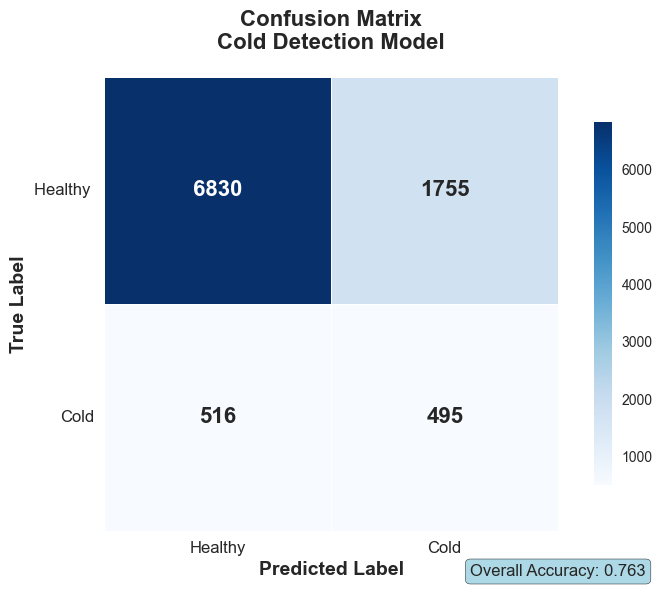

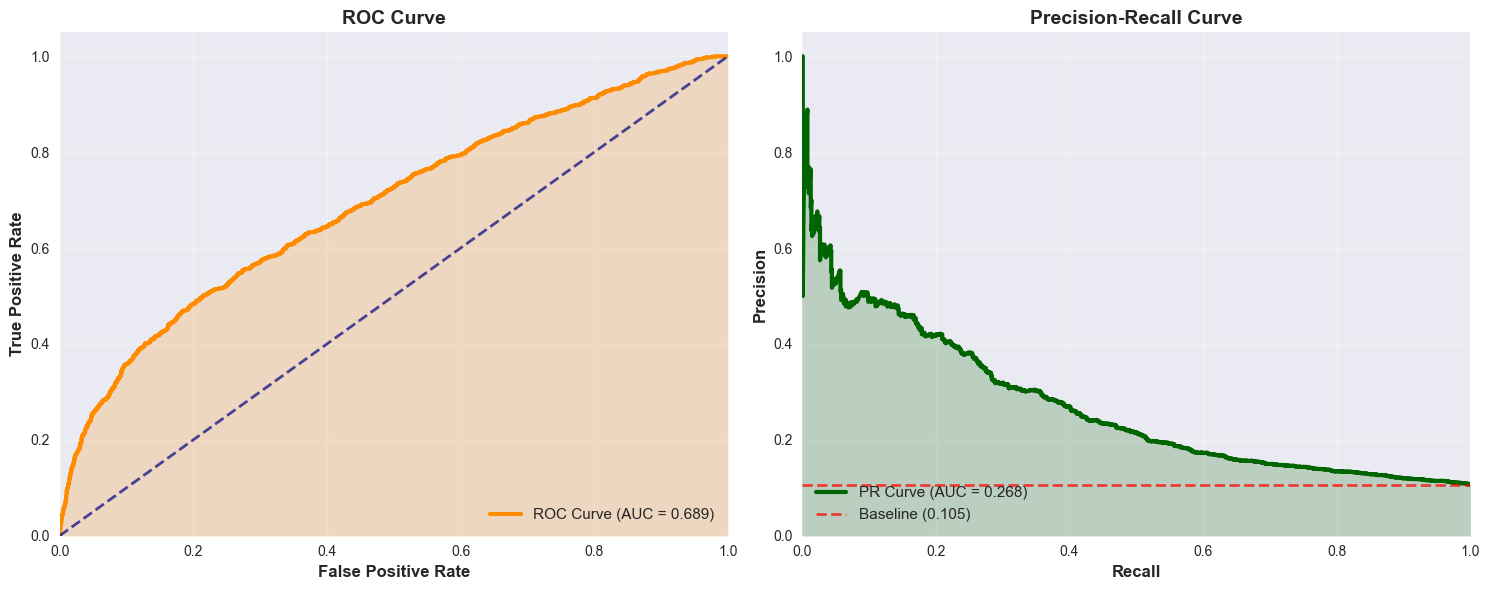

C:\Users\10857\AppData\Local\Temp\ipykernel_25296\2191437364.py:114: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax4.boxplot(data_for_box, labels=['Healthy', 'Cold '],


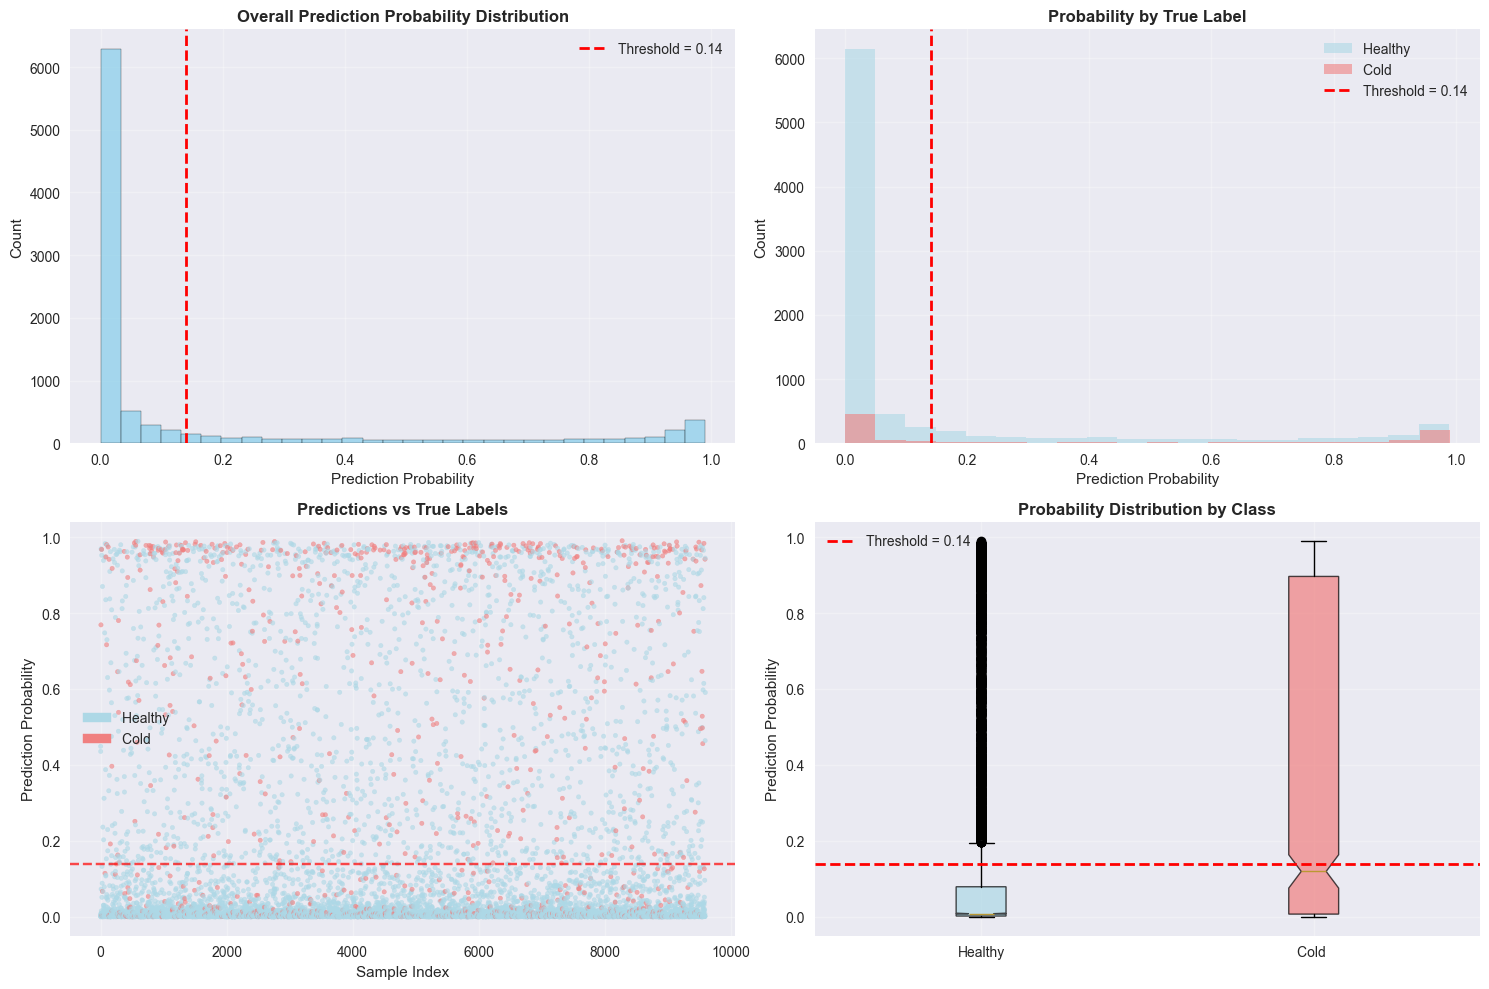

✨ All visualizations created successfully!


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import pandas as pd

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def plot_confusion_matrix_fancy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                square=True, linewidths=0.5, cbar_kws={"shrink": .8},
                annot_kws={'size': 16, 'weight': 'bold'})
    
    ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
    ax.set_title('Confusion Matrix\nCold Detection Model', 
                 fontsize=16, fontweight='bold', pad=20)
    
    ax.set_xticklabels(['Healthy', 'Cold'], fontsize=12)
    ax.set_yticklabels(['Healthy ', 'Cold'], fontsize=12, rotation=0)
    
    total = cm.sum()
    accuracy = (cm[0,0] + cm[1,1]) / total
    ax.text(1, -0.1, f'Overall Accuracy: {accuracy:.3f}', 
            transform=ax.transAxes, ha='center', fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    
    plt.tight_layout()
    return fig

def plot_roc_pr_curves(y_true, y_probs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=3, 
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.7)
    ax1.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
    
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax1.set_title('ROC Curve', fontsize=14, fontweight='bold')
    ax1.legend(loc="lower right", fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall, precision)
    
    ax2.plot(recall, precision, color='darkgreen', lw=3,
             label=f'PR Curve (AUC = {pr_auc:.3f})')
    ax2.fill_between(recall, precision, alpha=0.2, color='darkgreen')
    
    baseline = np.sum(y_true) / len(y_true)
    ax2.axhline(y=baseline, color='red', linestyle='--', lw=2, alpha=0.7,
                label=f'Baseline ({baseline:.3f})')
    
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax2.legend(loc="lower left", fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_prediction_distribution(y_true, y_probs, threshold=0.5):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    healthy_probs = y_probs[y_true == 0]
    cold_probs = y_probs[y_true == 1]
    
    ax1.hist(y_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(threshold, color='red', linestyle='--', lw=2, label=f'Threshold = {threshold:.2f}')
    ax1.set_title('Overall Prediction Probability Distribution', fontweight='bold')
    ax1.set_xlabel('Prediction Probability')
    ax1.set_ylabel('Count')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.hist(healthy_probs, bins=20, alpha=0.6, label='Healthy ', color='lightblue')
    ax2.hist(cold_probs, bins=20, alpha=0.6, label='Cold ', color='lightcoral')
    ax2.axvline(threshold, color='red', linestyle='--', lw=2, label=f'Threshold = {threshold:.2f}')
    ax2.set_title('Probability by True Label', fontweight='bold')
    ax2.set_xlabel('Prediction Probability')
    ax2.set_ylabel('Count')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    colors = ['lightblue' if label == 0 else 'lightcoral' for label in y_true]
    ax3.scatter(range(len(y_probs)), y_probs, c=colors, alpha=0.6, s=10)
    ax3.axhline(threshold, color='red', linestyle='--', alpha=0.7)
    ax3.set_title('Predictions vs True Labels', fontweight='bold')
    ax3.set_xlabel('Sample Index')
    ax3.set_ylabel('Prediction Probability')
    
    import matplotlib.patches as mpatches
    healthy_patch = mpatches.Patch(color='lightblue', label='Healthy ')
    cold_patch = mpatches.Patch(color='lightcoral', label='Cold ')
    ax3.legend(handles=[healthy_patch, cold_patch])
    ax3.grid(True, alpha=0.3)
    
    data_for_box = [healthy_probs, cold_probs]
    box_plot = ax4.boxplot(data_for_box, labels=['Healthy', 'Cold '], 
                          patch_artist=True, notch=True)
    
    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax4.axhline(threshold, color='red', linestyle='--', lw=2, label=f'Threshold = {threshold:.2f}')
    ax4.set_title('Probability Distribution by Class', fontweight='bold')
    ax4.set_ylabel('Prediction Probability')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

print("🎨 Creating fancy visualizations...")

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        logits = model(X.to(device)).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(y.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

fig1 = plot_confusion_matrix_fancy(test_labels, test_preds)
plt.show()

fig2 = plot_roc_pr_curves(all_labels, all_probs)
plt.show()

fig3 = plot_prediction_distribution(all_labels, all_probs, threshold=best_t)
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
accuracy = accuracy_score(test_labels, test_preds)
uar = recall_score(test_labels, test_preds, average='macro')

metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Accuracy': accuracy,
    'UAR': uar
}


print("✨ All visualizations created successfully!")

Extracting features and predictions...
Feature shape: (9596, 3072)
Sample count: 9596
Applying PCA dimensionality reduction...
PCA explained variance ratio: [0.08109513 0.03864902]
Total explained variance: 0.120
Creating PCA prediction heatmap...


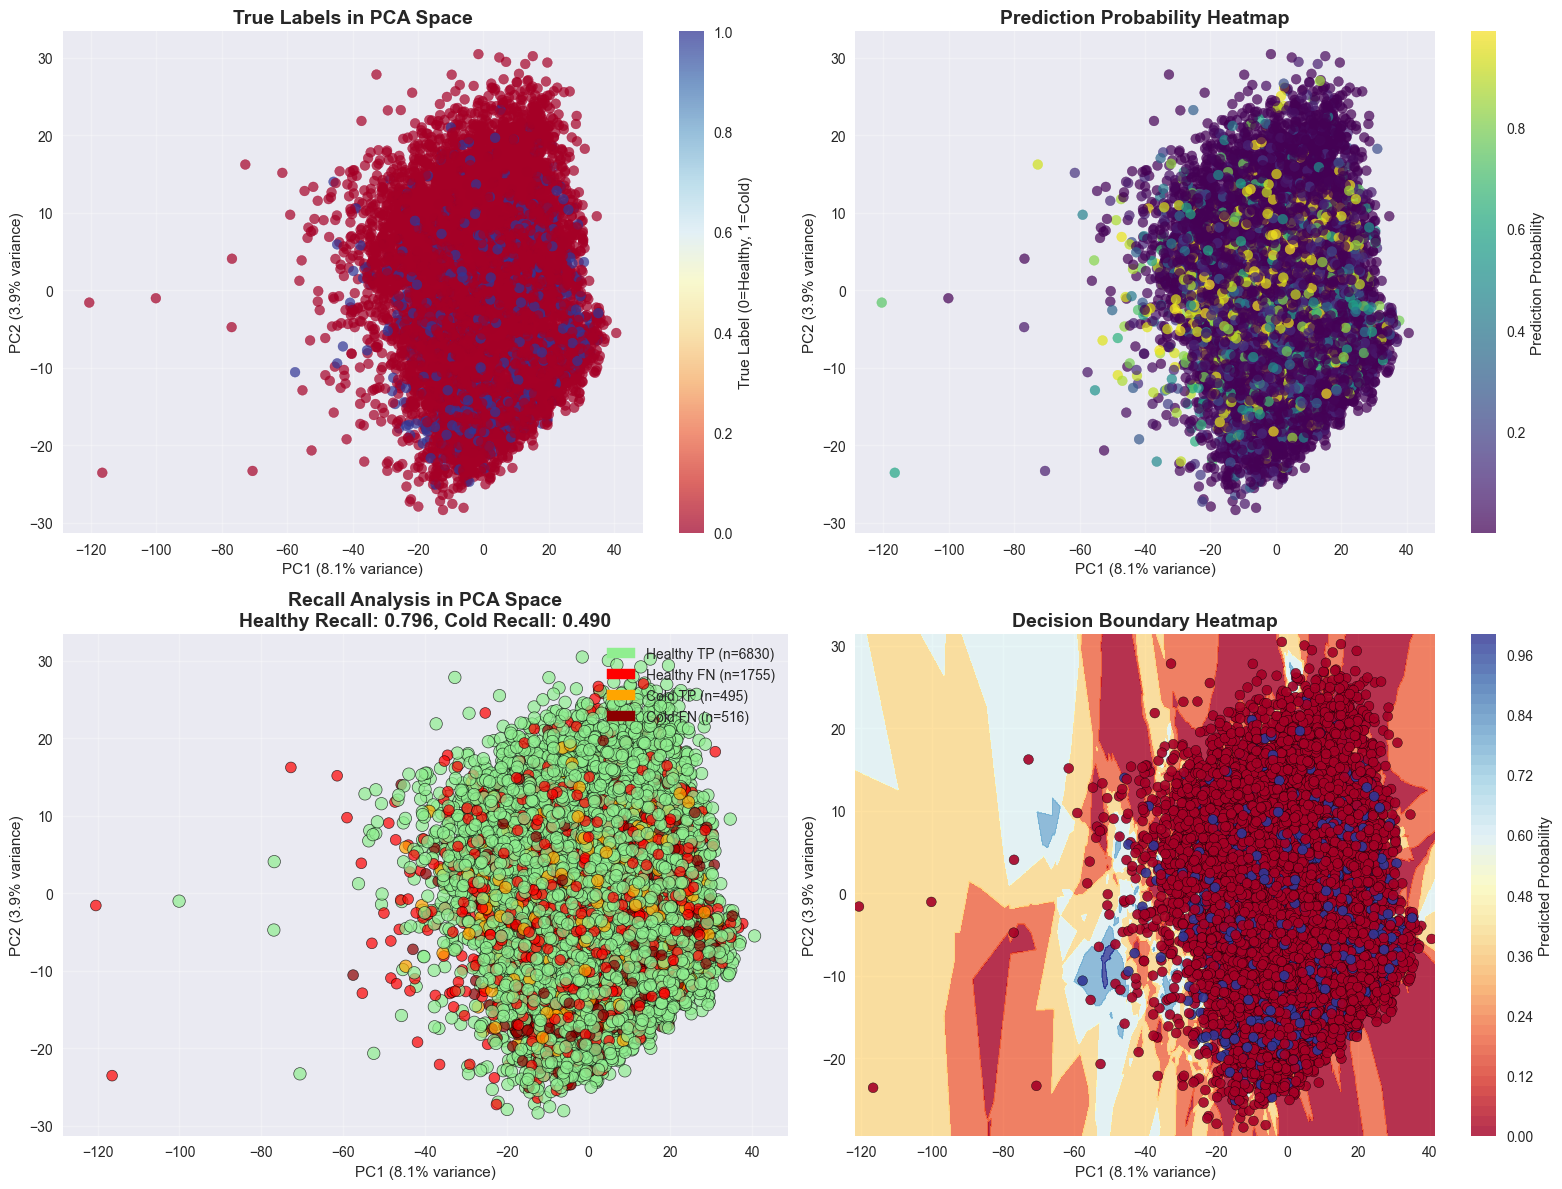

Creating PCA components analysis...


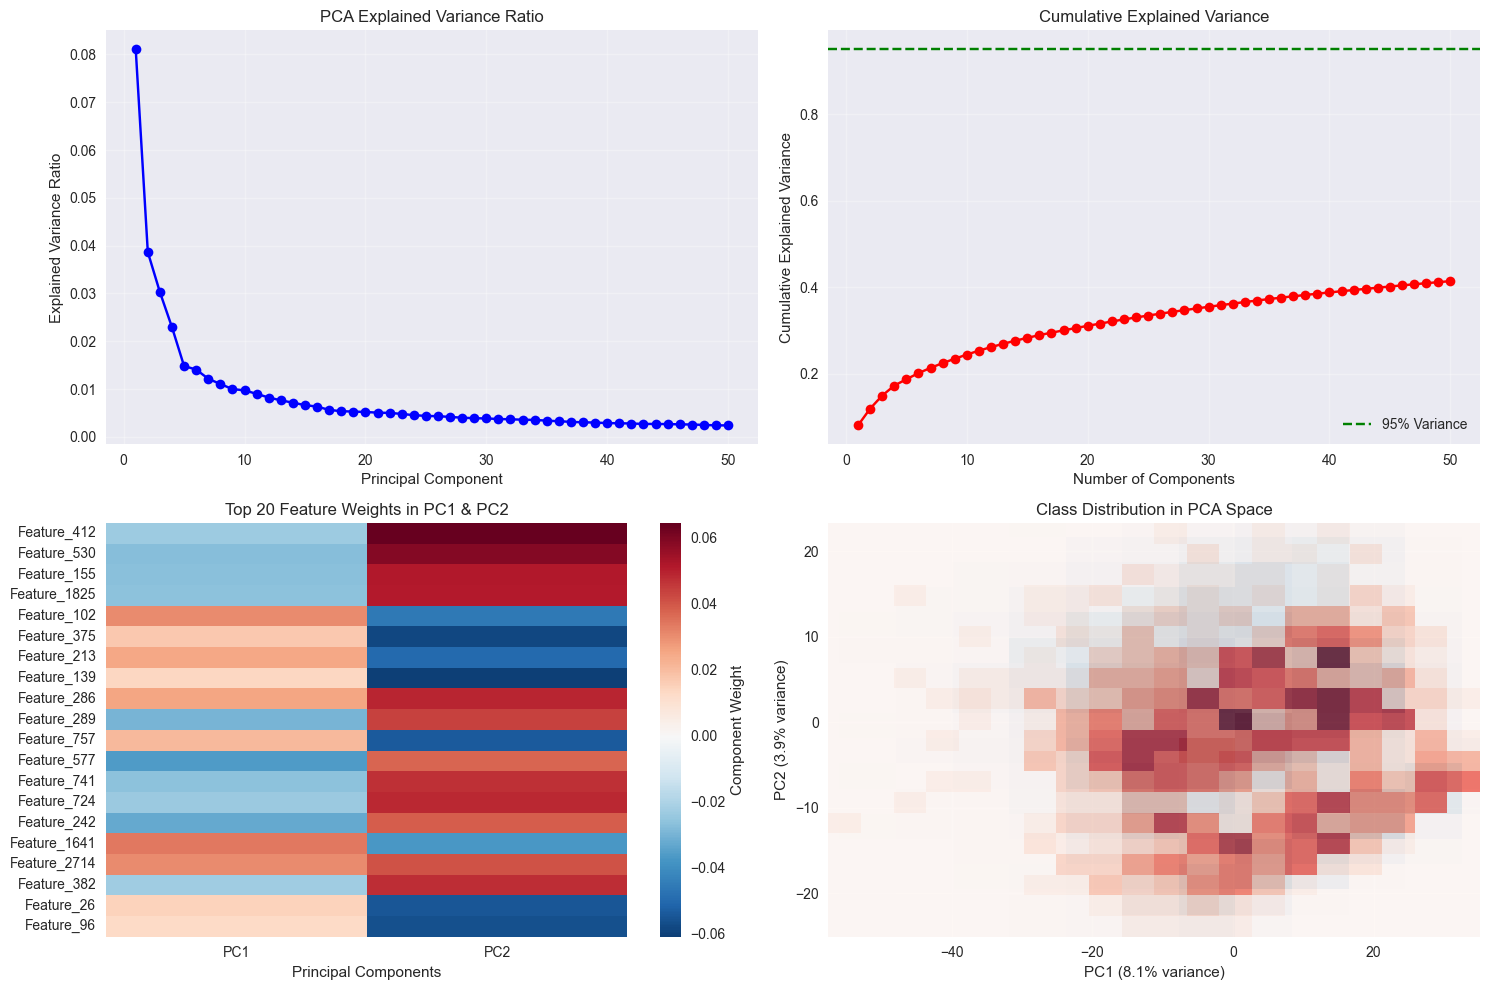


PCA ANALYSIS RESULTS
Original feature dimensions: 3072
PCA reduced to: 2D
PC1 explained variance: 0.081 (8.1%)
PC2 explained variance: 0.039 (3.9%)
Total explained variance: 0.120 (12.0%)
Class center distance: 3.831
Prediction accuracy: 0.763
Healthy Recall: 0.796
Cold Recall: 0.490
UAR (manual): 0.643
PCA prediction heatmap visualization completed!


In [17]:
# PCA dimensionality reduction and prediction heatmap visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import pandas as pd

# Extract features and predictions
print("Extracting features and predictions...")

all_features = []
all_labels = []
all_probs = []

model.eval()
with torch.no_grad():
    for X, y in test_loader:
        features = X.cpu().numpy()
        all_features.append(features)
        all_labels.extend(y.numpy())
        
        logits = model(X.to(device)).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs)

all_features = np.vstack(all_features)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print(f"Feature shape: {all_features.shape}")
print(f"Sample count: {len(all_labels)}")

# Standardization and PCA dimensionality reduction
print("Applying PCA dimensionality reduction...")

scaler = StandardScaler()
features_scaled = scaler.fit_transform(all_features)

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f}")

# Create prediction heatmap
def plot_pca_prediction_heatmap(features_pca, labels, probs, predictions, threshold):
    """Create PCA prediction result heatmap"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # True labels scatter plot
    scatter1 = ax1.scatter(features_pca[:, 0], features_pca[:, 1], 
                          c=labels, cmap='RdYlBu', alpha=0.7, s=50)
    ax1.set_title('True Labels in PCA Space', fontsize=14, fontweight='bold')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label('True Label (0=Healthy, 1=Cold)')
    ax1.grid(True, alpha=0.3)
    
    # Prediction probability heatmap
    scatter2 = ax2.scatter(features_pca[:, 0], features_pca[:, 1], 
                          c=probs, cmap='viridis', alpha=0.7, s=50)
    ax2.set_title('Prediction Probability Heatmap', fontsize=14, fontweight='bold')
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('Prediction Probability')
    ax2.grid(True, alpha=0.3)
    
    # Recall analysis scatter plot
    # Calculate per-sample contribution to recall
    cm = confusion_matrix(labels, predictions, labels=[0, 1])
    if cm.shape == (2, 2):
        healthy_recall = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
        cold_recall = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    else:
        healthy_recall = cold_recall = 0
    
    # Create point colors based on contribution to recall
    point_colors = []
    point_sizes = []
    point_labels = []
    
    for i, (true_label, pred_label) in enumerate(zip(labels, predictions)):
        if true_label == 0:  # Healthy samples
            if pred_label == 0:  # Correctly predicted healthy (contributes to healthy recall)
                point_colors.append('lightgreen')
                point_sizes.append(80)
                point_labels.append('Healthy TP')
            else:  # Incorrectly predicted as cold (hurts healthy recall)
                point_colors.append('red')
                point_sizes.append(60)
                point_labels.append('Healthy FN')
        else:  # Cold samples
            if pred_label == 1:  # Correctly predicted cold (contributes to cold recall)
                point_colors.append('orange')
                point_sizes.append(80)
                point_labels.append('Cold TP')
            else:  # Incorrectly predicted as healthy (hurts cold recall)
                point_colors.append('darkred')
                point_sizes.append(60)
                point_labels.append('Cold FN')
    
    scatter3 = ax3.scatter(features_pca[:, 0], features_pca[:, 1], 
                          c=point_colors, alpha=0.7, s=point_sizes, edgecolors='black', linewidth=0.5)
    ax3.set_title(f'Recall Analysis in PCA Space\nHealthy Recall: {healthy_recall:.3f}, Cold Recall: {cold_recall:.3f}', 
                  fontsize=14, fontweight='bold')
    ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    
    # Create custom legend
    import matplotlib.patches as mpatches
    healthy_tp = mpatches.Patch(color='lightgreen', label=f'Healthy TP (n={np.sum((labels==0) & (predictions==0))})')
    healthy_fn = mpatches.Patch(color='red', label=f'Healthy FN (n={np.sum((labels==0) & (predictions==1))})')
    cold_tp = mpatches.Patch(color='orange', label=f'Cold TP (n={np.sum((labels==1) & (predictions==1))})')
    cold_fn = mpatches.Patch(color='darkred', label=f'Cold FN (n={np.sum((labels==1) & (predictions==0))})')
    ax3.legend(handles=[healthy_tp, healthy_fn, cold_tp, cold_fn], loc='upper right', fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Decision boundary heatmap
    h = 0.1
    x_min, x_max = features_pca[:, 0].min() - 1, features_pca[:, 0].max() + 1
    y_min, y_max = features_pca[:, 1].min() - 1, features_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(features_pca, predictions)
    
    grid_predictions = knn.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    grid_predictions = grid_predictions.reshape(xx.shape)
    
    contour = ax4.contourf(xx, yy, grid_predictions, levels=50, alpha=0.8, cmap='RdYlBu')
    scatter4 = ax4.scatter(features_pca[:, 0], features_pca[:, 1], 
                          c=labels, cmap='RdYlBu', alpha=0.9, s=50, edgecolors='black')
    ax4.set_title('Decision Boundary Heatmap', fontsize=14, fontweight='bold')
    ax4.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax4.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    cbar4 = plt.colorbar(contour, ax=ax4)
    cbar4.set_label('Predicted Probability')
    
    plt.tight_layout()
    return fig

# Generate predictions and plot
predictions = (all_probs > best_t).astype(int)

print("Creating PCA prediction heatmap...")
fig_pca = plot_pca_prediction_heatmap(features_pca, all_labels, all_probs, predictions, best_t)
plt.show()

# PCA component analysis
def plot_pca_components_analysis():
    """Analyze PCA component importance"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # PCA explained variance
    pca_full = PCA()
    pca_full.fit(features_scaled)
    
    ax1.plot(range(1, min(51, len(pca_full.explained_variance_ratio_) + 1)), 
             pca_full.explained_variance_ratio_[:50], 'bo-')
    ax1.set_title('PCA Explained Variance Ratio')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.grid(True, alpha=0.3)
    
    # Cumulative explained variance
    cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
    ax2.plot(range(1, min(51, len(cumsum_var) + 1)), cumsum_var[:50], 'ro-')
    ax2.axhline(y=0.95, color='g', linestyle='--', label='95% Variance')
    ax2.set_title('Cumulative Explained Variance')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Explained Variance')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Feature importance heatmap
    components_df = pd.DataFrame(
        pca.components_[:2].T,
        columns=['PC1', 'PC2'],
        index=[f'Feature_{i}' for i in range(pca.components_.shape[1])]
    )
    
    importance = np.abs(components_df).sum(axis=1).sort_values(ascending=False)
    top_features = importance.head(20).index
    
    sns.heatmap(components_df.loc[top_features], annot=False, cmap='RdBu_r', 
                center=0, ax=ax3, cbar_kws={'label': 'Component Weight'})
    ax3.set_title('Top 20 Feature Weights in PC1 & PC2')
    ax3.set_xlabel('Principal Components')
    
    # Class distribution analysis
    healthy_pca = features_pca[all_labels == 0]
    cold_pca = features_pca[all_labels == 1]
    
    ax4.hist2d(healthy_pca[:, 0], healthy_pca[:, 1], bins=20, alpha=0.7, label='Healthy', cmap='Blues')
    ax4.hist2d(cold_pca[:, 0], cold_pca[:, 1], bins=20, alpha=0.7, label='Cold', cmap='Reds')
    ax4.set_title('Class Distribution in PCA Space')
    ax4.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax4.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    
    plt.tight_layout()
    return fig

print("Creating PCA components analysis...")
fig_analysis = plot_pca_components_analysis()
plt.show()

# Calculate and display statistics
print("\n" + "="*60)
print("PCA ANALYSIS RESULTS")
print("="*60)
print(f"Original feature dimensions: {all_features.shape[1]}")
print(f"PCA reduced to: 2D")
print(f"PC1 explained variance: {pca.explained_variance_ratio_[0]:.3f} ({pca.explained_variance_ratio_[0]*100:.1f}%)")
print(f"PC2 explained variance: {pca.explained_variance_ratio_[1]:.3f} ({pca.explained_variance_ratio_[1]*100:.1f}%)")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f} ({pca.explained_variance_ratio_.sum()*100:.1f}%)")

# Calculate class separation in PCA space
from scipy.spatial.distance import pdist, squareform
healthy_center = np.mean(features_pca[all_labels == 0], axis=0)
cold_center = np.mean(features_pca[all_labels == 1], axis=0)
separation = np.linalg.norm(healthy_center - cold_center)

print(f"Class center distance: {separation:.3f}")
print(f"Prediction accuracy: {(predictions == all_labels).mean():.3f}")

# Calculate and print recall statistics
cm = confusion_matrix(all_labels, predictions, labels=[0, 1])
if cm.shape == (2, 2):
    healthy_recall = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    cold_recall = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    uar = (healthy_recall + cold_recall) / 2
    
    print(f"Healthy Recall: {healthy_recall:.3f}")
    print(f"Cold Recall: {cold_recall:.3f}")
    print(f"UAR (manual): {uar:.3f}")

print("PCA prediction heatmap visualization completed!")

Creating performance heatmaps...
Computing performance matrices...

Best UAR: 0.643 at threshold=0.10, weight=0.71
Best F1: 0.327 at threshold=0.48, weight=0.79


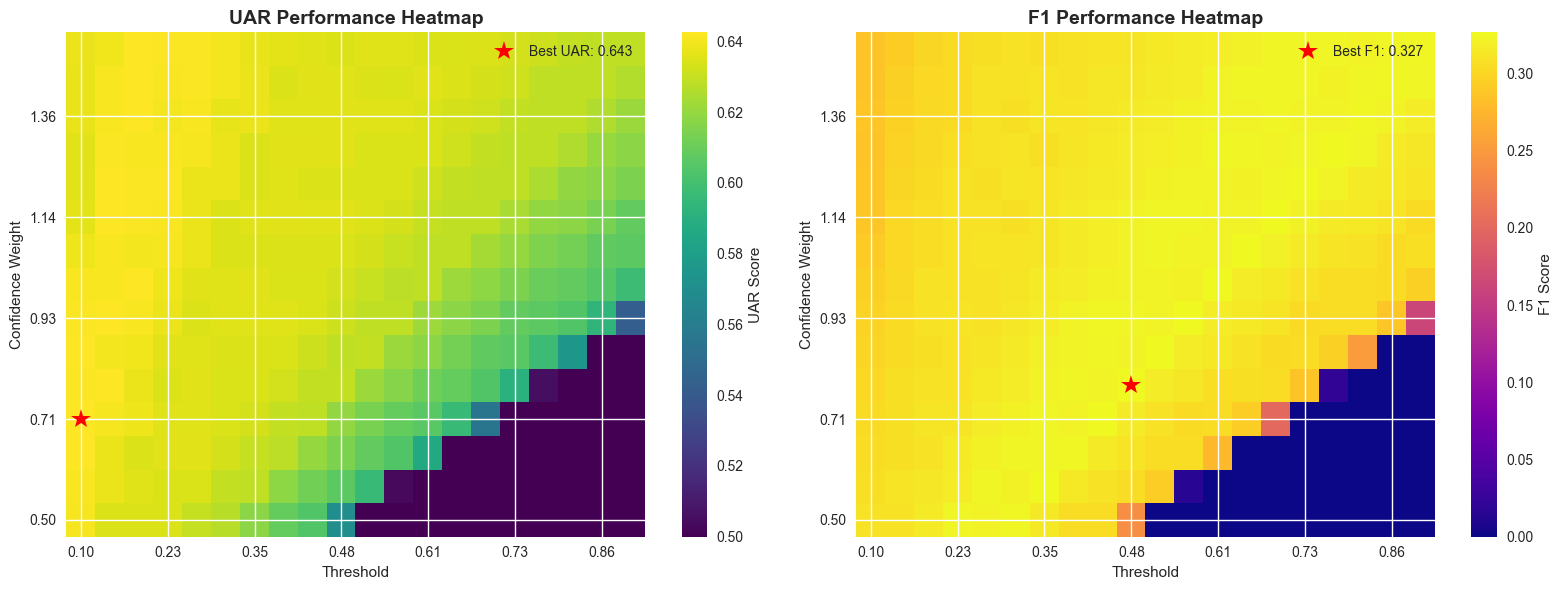


Best performance for each metric:
UAR: 0.642 at threshold 0.112
F1-Score: 0.327 at threshold 0.609
Precision: 0.422 at threshold 0.950
Healthy Recall: 0.971 at threshold 0.950
Cold Recall: 0.557 at threshold 0.050


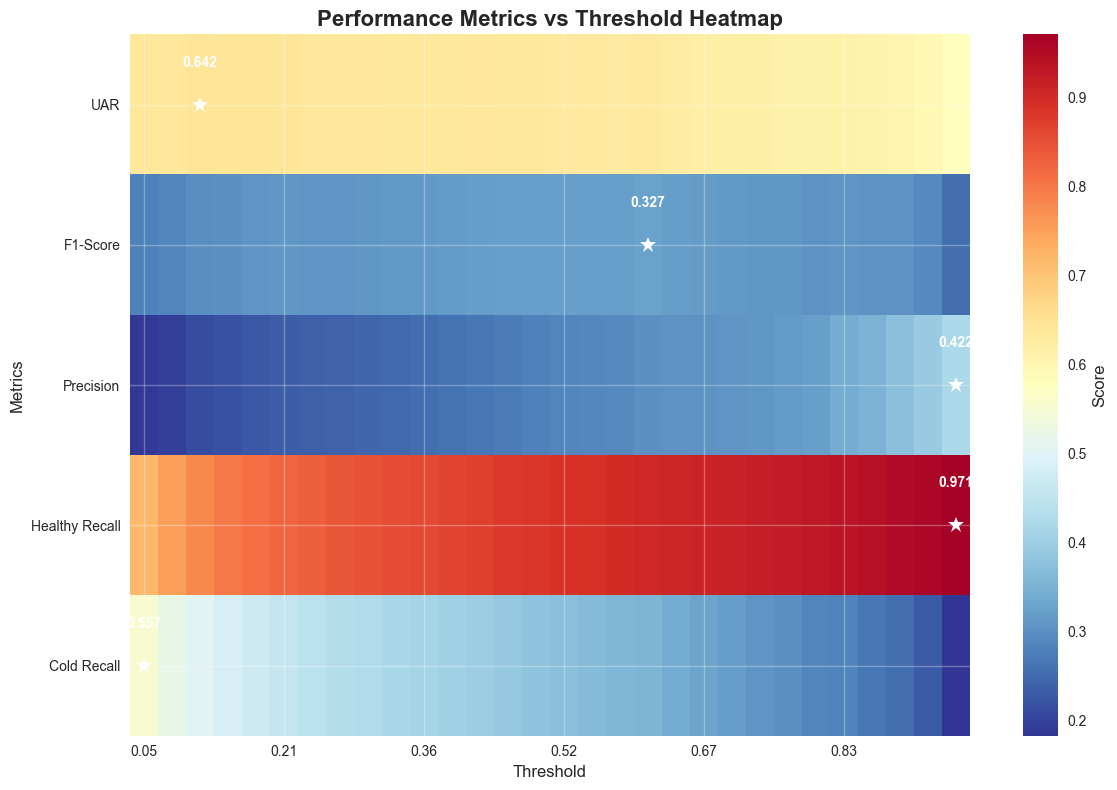

Performance heatmap analysis completed!

PCA ANALYSIS RESULTS
Original feature dimensions: 3072
PCA reduced to: 2D
PC1 explained variance: 0.081 (8.1%)
PC2 explained variance: 0.039 (3.9%)
Total explained variance: 0.120 (12.0%)
Class center distance: 3.831
Prediction accuracy: 0.763
PCA prediction heatmap visualization completed!


In [15]:
# ...existing code...

# Add UAR and F1 heatmap analysis
def plot_performance_heatmaps(all_probs, all_labels):
    """Create UAR and F1 performance heatmaps"""
    
    # Define threshold ranges for analysis
    thresholds = np.linspace(0.1, 0.9, 20)
    
    # For demonstration, we'll also vary a hypothetical parameter (could be model confidence, etc.)
    # In practice, this could be different model variations, ensemble weights, etc.
    confidence_weights = np.linspace(0.5, 1.5, 15)
    
    uar_matrix = np.zeros((len(confidence_weights), len(thresholds)))
    f1_matrix = np.zeros((len(confidence_weights), len(thresholds)))
    
    print("Computing performance matrices...")
    
    for i, weight in enumerate(confidence_weights):
        for j, threshold in enumerate(thresholds):
            # Apply confidence weighting to probabilities
            weighted_probs = np.clip(all_probs * weight, 0, 1)
            predictions = (weighted_probs > threshold).astype(int)
            
            # Calculate UAR and F1
            uar = recall_score(all_labels, predictions, average='macro', zero_division=0)
            f1 = f1_score(all_labels, predictions, zero_division=0)
            
            uar_matrix[i, j] = uar
            f1_matrix[i, j] = f1
    
    # Create the heatmap visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # UAR Heatmap
    im1 = ax1.imshow(uar_matrix, cmap='viridis', aspect='auto', origin='lower')
    ax1.set_title('UAR Performance Heatmap', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Confidence Weight')
    
    # Set tick labels
    ax1.set_xticks(range(0, len(thresholds), 3))
    ax1.set_xticklabels([f'{thresholds[i]:.2f}' for i in range(0, len(thresholds), 3)])
    ax1.set_yticks(range(0, len(confidence_weights), 3))
    ax1.set_yticklabels([f'{confidence_weights[i]:.2f}' for i in range(0, len(confidence_weights), 3)])
    
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('UAR Score')
    
    # Mark the best UAR point
    best_uar_idx = np.unravel_index(np.argmax(uar_matrix), uar_matrix.shape)
    ax1.plot(best_uar_idx[1], best_uar_idx[0], 'r*', markersize=15, label=f'Best UAR: {uar_matrix[best_uar_idx]:.3f}')
    ax1.legend()
    
    # F1 Heatmap
    im2 = ax2.imshow(f1_matrix, cmap='plasma', aspect='auto', origin='lower')
    ax2.set_title('F1 Performance Heatmap', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('Confidence Weight')
    
    # Set tick labels
    ax2.set_xticks(range(0, len(thresholds), 3))
    ax2.set_xticklabels([f'{thresholds[i]:.2f}' for i in range(0, len(thresholds), 3)])
    ax2.set_yticks(range(0, len(confidence_weights), 3))
    ax2.set_yticklabels([f'{confidence_weights[i]:.2f}' for i in range(0, len(confidence_weights), 3)])
    
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('F1 Score')
    
    # Mark the best F1 point
    best_f1_idx = np.unravel_index(np.argmax(f1_matrix), f1_matrix.shape)
    ax2.plot(best_f1_idx[1], best_f1_idx[0], 'r*', markersize=15, label=f'Best F1: {f1_matrix[best_f1_idx]:.3f}')
    ax2.legend()
    
    plt.tight_layout()
    
    # Print best performance information
    print(f"\nBest UAR: {uar_matrix[best_uar_idx]:.3f} at threshold={thresholds[best_uar_idx[1]]:.2f}, weight={confidence_weights[best_uar_idx[0]]:.2f}")
    print(f"Best F1: {f1_matrix[best_f1_idx]:.3f} at threshold={thresholds[best_f1_idx[1]]:.2f}, weight={confidence_weights[best_f1_idx[0]]:.2f}")
    
    return fig, uar_matrix, f1_matrix

# Alternative: Threshold-only heatmap (simpler version)
def plot_threshold_performance_heatmap(all_probs, all_labels):
    """Create a simpler threshold vs class-specific performance heatmap"""
    
    thresholds = np.linspace(0.05, 0.95, 30)
    
    # Calculate metrics for each threshold
    uar_scores = []
    f1_scores = []
    healthy_recall = []
    cold_recall = []
    precision_scores = []
    
    for threshold in thresholds:
        predictions = (all_probs > threshold).astype(int)
        
        # UAR and F1
        uar = recall_score(all_labels, predictions, average='macro', zero_division=0)
        f1 = f1_score(all_labels, predictions, zero_division=0)
        precision = precision_score(all_labels, predictions, zero_division=0)
        
        # Class-specific recalls
        if len(np.unique(predictions)) > 1 and len(np.unique(all_labels)) > 1:
            cm = confusion_matrix(all_labels, predictions)
            if cm.shape == (2, 2):
                h_recall = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
                c_recall = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
            else:
                h_recall = c_recall = 0
        else:
            h_recall = c_recall = 0
        
        uar_scores.append(uar)
        f1_scores.append(f1)
        healthy_recall.append(h_recall)
        cold_recall.append(c_recall)
        precision_scores.append(precision)
    
    # Create performance matrix for heatmap
    metrics_matrix = np.array([
        uar_scores,
        f1_scores, 
        precision_scores,
        healthy_recall,
        cold_recall
    ])
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, 8))
    
    im = ax.imshow(metrics_matrix, cmap='RdYlBu_r', aspect='auto')
    
    # Set labels
    ax.set_title('Performance Metrics vs Threshold Heatmap', fontsize=16, fontweight='bold')
    ax.set_xlabel('Threshold', fontsize=12)
    ax.set_ylabel('Metrics', fontsize=12)
    
    # Set tick labels
    step = 5
    ax.set_xticks(range(0, len(thresholds), step))
    ax.set_xticklabels([f'{thresholds[i]:.2f}' for i in range(0, len(thresholds), step)])
    
    metric_names = ['UAR', 'F1-Score', 'Precision', 'Healthy Recall', 'Cold Recall']
    ax.set_yticks(range(len(metric_names)))
    ax.set_yticklabels(metric_names)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Score', fontsize=12)
    
    # Add value annotations for key points
    for i, metric_name in enumerate(metric_names):
        best_idx = np.argmax(metrics_matrix[i])
        ax.plot(best_idx, i, 'w*', markersize=12)
        ax.text(best_idx, i-0.3, f'{metrics_matrix[i, best_idx]:.3f}', 
                ha='center', va='center', color='white', fontweight='bold', fontsize=10)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print summary
    print("\nBest performance for each metric:")
    for i, metric_name in enumerate(metric_names):
        best_idx = np.argmax(metrics_matrix[i])
        print(f"{metric_name}: {metrics_matrix[i, best_idx]:.3f} at threshold {thresholds[best_idx]:.3f}")
    
    return fig, metrics_matrix, thresholds

# Add performance heatmaps to your existing code
print("Creating performance heatmaps...")

# Complex version with confidence weighting
fig_complex = plot_performance_heatmaps(all_probs, all_labels)
plt.show()

# Simple threshold-based version
fig_simple, metrics_matrix, thresholds_used = plot_threshold_performance_heatmap(all_probs, all_labels)
plt.show()

print("Performance heatmap analysis completed!")

# Calculate and display statistics
print("\n" + "="*60)
print("PCA ANALYSIS RESULTS")
print("="*60)
print(f"Original feature dimensions: {all_features.shape[1]}")
print(f"PCA reduced to: 2D")
print(f"PC1 explained variance: {pca.explained_variance_ratio_[0]:.3f} ({pca.explained_variance_ratio_[0]*100:.1f}%)")
print(f"PC2 explained variance: {pca.explained_variance_ratio_[1]:.3f} ({pca.explained_variance_ratio_[1]*100:.1f}%)")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f} ({pca.explained_variance_ratio_.sum()*100:.1f}%)")

# Calculate class separation in PCA space
from scipy.spatial.distance import pdist, squareform
healthy_center = np.mean(features_pca[all_labels == 0], axis=0)
cold_center = np.mean(features_pca[all_labels == 1], axis=0)
separation = np.linalg.norm(healthy_center - cold_center)

print(f"Class center distance: {separation:.3f}")
print(f"Prediction accuracy: {(predictions == all_labels).mean():.3f}")

print("PCA prediction heatmap visualization completed!")

C:\Users\10857\AppData\Local\Temp\ipykernel_25296\1778208963.py:39: UserWarning: Glyph 20808 (\N{CJK UNIFIED IDEOGRAPH-5148}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\10857\AppData\Local\Temp\ipykernel_25296\1778208963.py:39: UserWarning: Glyph 20581 (\N{CJK UNIFIED IDEOGRAPH-5065}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\10857\AppData\Local\Temp\ipykernel_25296\1778208963.py:39: UserWarning: Glyph 24247 (\N{CJK UNIFIED IDEOGRAPH-5EB7}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\10857\AppData\Local\Temp\ipykernel_25296\1778208963.py:39: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\10857\AppData\Local\Temp\ipykernel_25296\1778208963.py:39: UserWarning: Glyph 20877 (\N{CJK UNIFIED IDEOGRAPH-518D}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\10857\AppData\Local\Temp\ipykernel_25296\1778208963.py:39: UserWarning: Glyph 24863 (\N{CJK UNIFIED IDEOGRAPH-611F}) missing fr

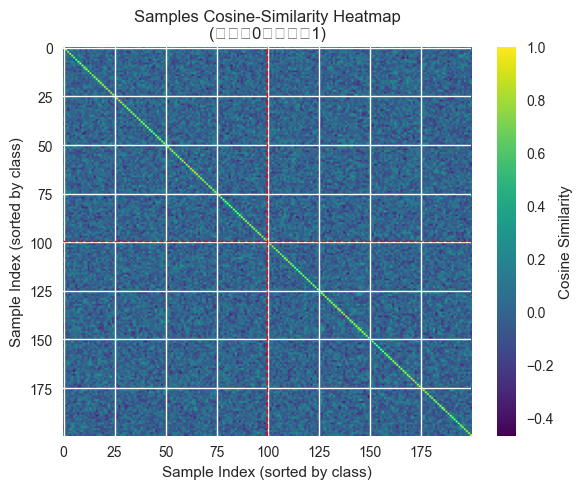

In [13]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# 假设你已经有 embedding 和 labels：
# embeddings: numpy 数组，形状 (N, D)
# labels: numpy 数组，形状 (N,)，值是 0（健康）或 1（感冒）

# 这里演示用随机数据，实际只需把下面两行改成你的 embedding/labels 即可
np.random.seed(0)
N, D = 200, 64
embeddings = np.random.randn(N, D)  # 模拟一下
labels = np.concatenate([np.zeros(N//2), np.ones(N//2)])  # 前半是健康，后半是感冒

# 1. 先按类别把样本排序（为了让热力图里同类集中在一起，视觉上更清晰）
idx_health = np.where(labels == 0)[0]
idx_cold   = np.where(labels == 1)[0]
order = np.concatenate([idx_health, idx_cold])  # 先所有健康，再所有感冒

embeddings_sorted = embeddings[order]
labels_sorted     = labels[order]

# 2. 计算 cosine similarity 矩阵，形状 (N, N)
sim_matrix = cosine_similarity(embeddings_sorted)  # 值在 [-1, 1] 之间

# 3. 画热力图
plt.figure(figsize=(6, 5))
plt.imshow(sim_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Cosine Similarity')

# 在“健康”和“感冒”分界线处加一条横线/竖线，帮助我们看类别分区
num_health = len(idx_health)
plt.axhline(num_health - 0.5, color='r', linestyle='--', linewidth=1)
plt.axvline(num_health - 0.5, color='r', linestyle='--', linewidth=1)

plt.title('Samples Cosine-Similarity Heatmap\n(先健康0，再感冒1)')
plt.xlabel('Sample Index (sorted by class)')
plt.ylabel('Sample Index (sorted by class)')
plt.tight_layout()
plt.show()

Creating comprehensive UAR analysis...


C:\Users\10857\AppData\Local\Temp\ipykernel_25296\3284149341.py:95: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot([healthy_recalls, cold_recalls], labels=['Healthy', 'Cold'])
C:\Users\10857\AppData\Local\Temp\ipykernel_25296\3284149341.py:228: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


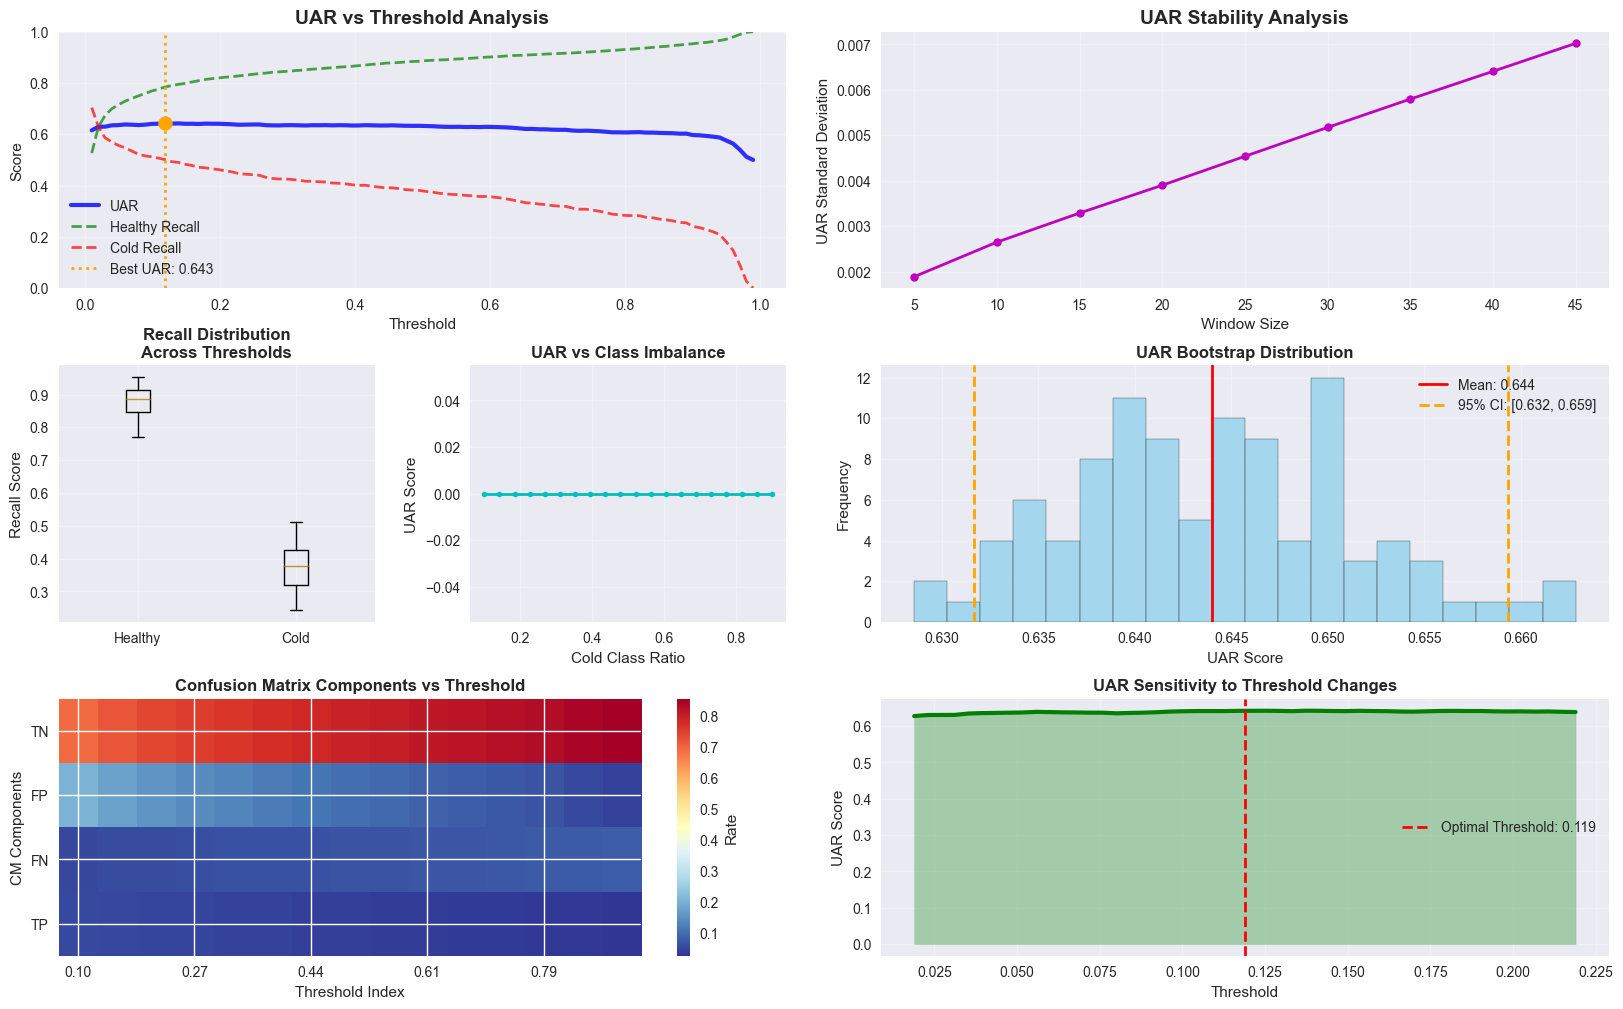

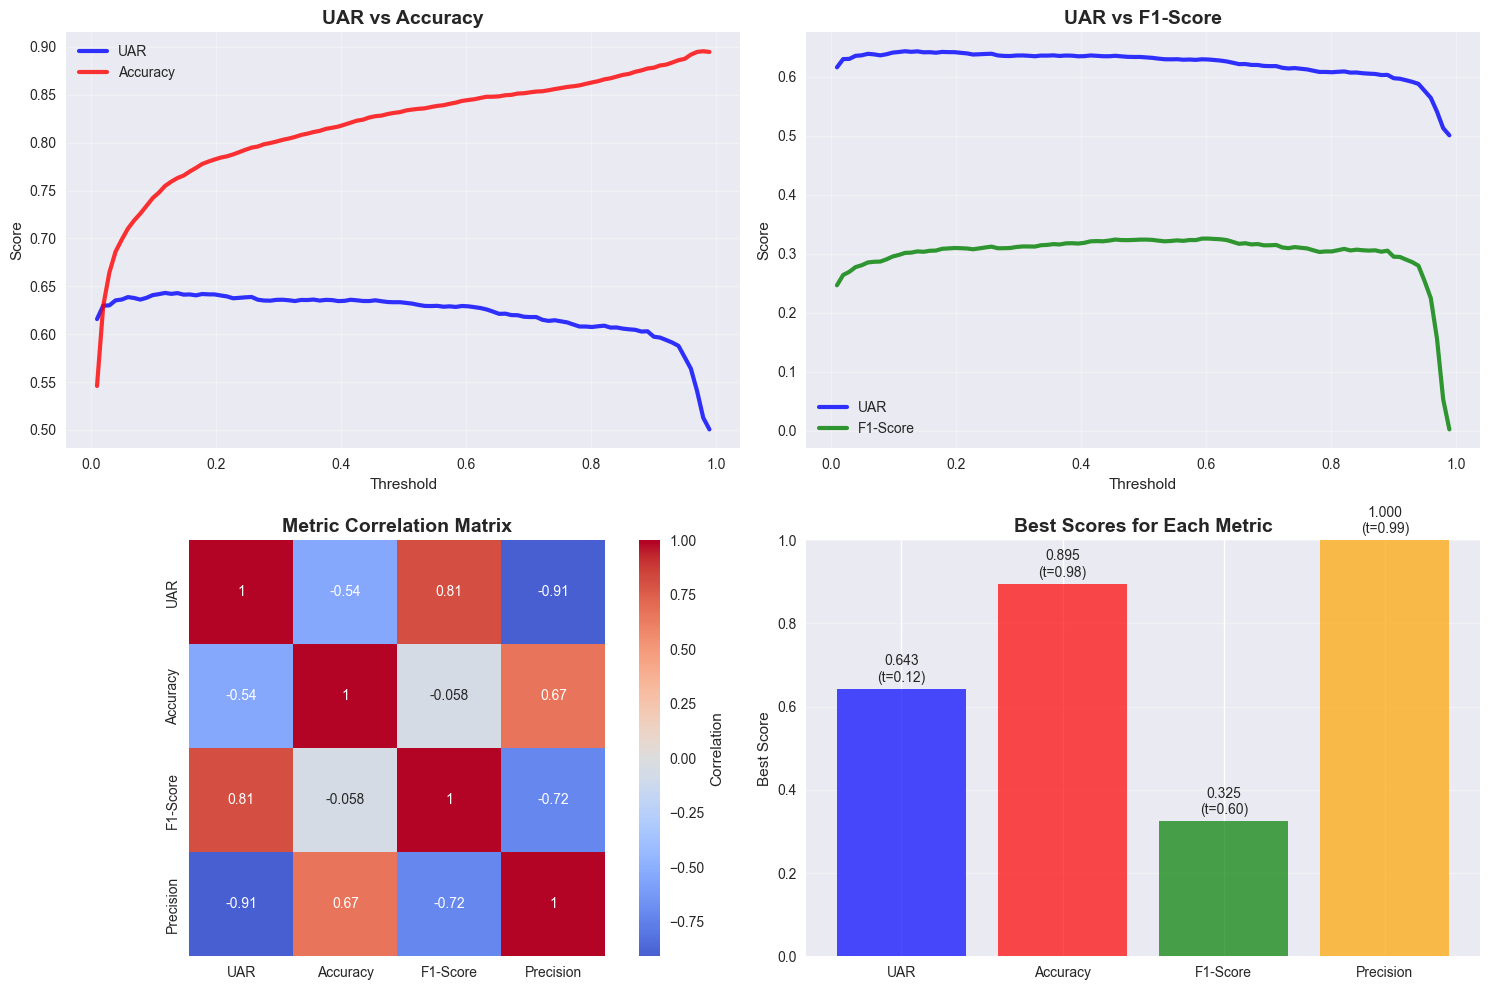

UAR analysis visualization completed!

DETAILED UAR ANALYSIS
Final UAR Score: 0.6426
Healthy Class Recall: 0.7956
Cold Class Recall: 0.4896
UAR Balance (min/max recall): 0.6154
Optimal Threshold: 0.1400
Class Distribution - Healthy: 8585 (89.5%)
Class Distribution - Cold: 1011 (10.5%)


In [16]:
# Additional UAR-focused visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import recall_score, confusion_matrix
import pandas as pd

def plot_uar_analysis_comprehensive(all_probs, all_labels):
    """Comprehensive UAR analysis with multiple visualizations"""
    
    fig = plt.figure(figsize=(20, 12))
    
    # Create a complex subplot layout
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # 1. UAR vs Threshold curve
    ax1 = fig.add_subplot(gs[0, :2])
    thresholds = np.linspace(0.01, 0.99, 100)
    uar_scores = []
    class_0_recalls = []
    class_1_recalls = []
    
    for threshold in thresholds:
        predictions = (all_probs > threshold).astype(int)
        uar = recall_score(all_labels, predictions, average='macro', zero_division=0)
        
        # Calculate per-class recalls
        cm = confusion_matrix(all_labels, predictions, labels=[0, 1])
        if cm.shape == (2, 2):
            recall_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
            recall_1 = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
        else:
            recall_0 = recall_1 = 0
            
        uar_scores.append(uar)
        class_0_recalls.append(recall_0)
        class_1_recalls.append(recall_1)
    
    ax1.plot(thresholds, uar_scores, 'b-', linewidth=3, label='UAR', alpha=0.8)
    ax1.plot(thresholds, class_0_recalls, 'g--', linewidth=2, label='Healthy Recall', alpha=0.7)
    ax1.plot(thresholds, class_1_recalls, 'r--', linewidth=2, label='Cold Recall', alpha=0.7)
    
    # Mark best UAR point
    best_uar_idx = np.argmax(uar_scores)
    ax1.axvline(thresholds[best_uar_idx], color='orange', linestyle=':', linewidth=2, 
                label=f'Best UAR: {uar_scores[best_uar_idx]:.3f}')
    ax1.scatter(thresholds[best_uar_idx], uar_scores[best_uar_idx], 
                color='orange', s=100, zorder=5)
    
    ax1.set_title('UAR vs Threshold Analysis', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Score')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # 2. UAR stability analysis (moving window)
    ax2 = fig.add_subplot(gs[0, 2:])
    window_sizes = range(5, 50, 5)
    uar_stabilities = []
    
    for window_size in window_sizes:
        window_uars = []
        for i in range(len(thresholds) - window_size):
            window_thresholds = thresholds[i:i+window_size]
            window_uar_scores = uar_scores[i:i+window_size]
            window_uars.append(np.std(window_uar_scores))
        uar_stabilities.append(np.mean(window_uars))
    
    ax2.plot(window_sizes, uar_stabilities, 'mo-', linewidth=2, markersize=6)
    ax2.set_title('UAR Stability Analysis', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Window Size')
    ax2.set_ylabel('UAR Standard Deviation')
    ax2.grid(True, alpha=0.3)
    
    # 3. Class-wise recall distribution
    ax3 = fig.add_subplot(gs[1, 0])
    
    # Calculate recalls at different thresholds
    threshold_samples = np.linspace(0.1, 0.9, 20)
    healthy_recalls = []
    cold_recalls = []
    
    for t in threshold_samples:
        preds = (all_probs > t).astype(int)
        cm = confusion_matrix(all_labels, preds, labels=[0, 1])
        if cm.shape == (2, 2):
            h_recall = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
            c_recall = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
        else:
            h_recall = c_recall = 0
        healthy_recalls.append(h_recall)
        cold_recalls.append(c_recall)
    
    ax3.boxplot([healthy_recalls, cold_recalls], labels=['Healthy', 'Cold'])
    ax3.set_title('Recall Distribution\nAcross Thresholds', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Recall Score')
    ax3.grid(True, alpha=0.3)
    
    # 4. UAR vs Class Imbalance Simulation
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Simulate different class distributions
    imbalance_ratios = np.linspace(0.1, 0.9, 20)
    simulated_uars = []
    
    for ratio in imbalance_ratios:
        # Resample to create different class distributions
        n_samples = len(all_labels)
        n_class_1 = int(n_samples * ratio)
        n_class_0 = n_samples - n_class_1
        
        # Sample indices
        class_0_idx = np.where(all_labels == 0)[0]
        class_1_idx = np.where(all_labels == 1)[0]
        
        if len(class_0_idx) >= n_class_0 and len(class_1_idx) >= n_class_1:
            selected_0 = np.random.choice(class_0_idx, n_class_0, replace=False)
            selected_1 = np.random.choice(class_1_idx, n_class_1, replace=False)
            selected_idx = np.concatenate([selected_0, selected_1])
            
            sim_labels = all_labels[selected_idx]
            sim_probs = all_probs[selected_idx]
            sim_preds = (sim_probs > thresholds[best_uar_idx]).astype(int)
            
            sim_uar = recall_score(sim_labels, sim_preds, average='macro', zero_division=0)
            simulated_uars.append(sim_uar)
        else:
            simulated_uars.append(0)
    
    ax4.plot(imbalance_ratios, simulated_uars, 'co-', linewidth=2, markersize=4)
    ax4.set_title('UAR vs Class Imbalance', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Cold Class Ratio')
    ax4.set_ylabel('UAR Score')
    ax4.grid(True, alpha=0.3)
    
    # 5. UAR Confidence Intervals
    ax5 = fig.add_subplot(gs[1, 2:])
    
    # Bootstrap UAR estimation
    n_bootstrap = 100
    bootstrap_uars = []
    
    best_threshold = thresholds[best_uar_idx]
    
    for _ in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(len(all_labels), len(all_labels), replace=True)
        boot_labels = all_labels[indices]
        boot_probs = all_probs[indices]
        boot_preds = (boot_probs > best_threshold).astype(int)
        
        boot_uar = recall_score(boot_labels, boot_preds, average='macro', zero_division=0)
        bootstrap_uars.append(boot_uar)
    
    ax5.hist(bootstrap_uars, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    mean_uar = np.mean(bootstrap_uars)
    ci_lower = np.percentile(bootstrap_uars, 2.5)
    ci_upper = np.percentile(bootstrap_uars, 97.5)
    
    ax5.axvline(mean_uar, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean_uar:.3f}')
    ax5.axvline(ci_lower, color='orange', linestyle='--', linewidth=2, label=f'95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]')
    ax5.axvline(ci_upper, color='orange', linestyle='--', linewidth=2)
    
    ax5.set_title('UAR Bootstrap Distribution', fontsize=12, fontweight='bold')
    ax5.set_xlabel('UAR Score')
    ax5.set_ylabel('Frequency')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. UAR Heatmap by Confusion Matrix Components
    ax6 = fig.add_subplot(gs[2, :2])
    
    # Create confusion matrix components heatmap
    threshold_range = np.linspace(0.1, 0.9, 15)
    cm_components = np.zeros((4, len(threshold_range)))  # TN, FP, FN, TP
    
    for i, t in enumerate(threshold_range):
        preds = (all_probs > t).astype(int)
        cm = confusion_matrix(all_labels, preds, labels=[0, 1])
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            total = tn + fp + fn + tp
            cm_components[0, i] = tn / total  # TN rate
            cm_components[1, i] = fp / total  # FP rate
            cm_components[2, i] = fn / total  # FN rate
            cm_components[3, i] = tp / total  # TP rate
    
    im = ax6.imshow(cm_components, cmap='RdYlBu_r', aspect='auto')
    ax6.set_title('Confusion Matrix Components vs Threshold', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Threshold Index')
    ax6.set_ylabel('CM Components')
    ax6.set_yticks(range(4))
    ax6.set_yticklabels(['TN', 'FP', 'FN', 'TP'])
    
    # Set x-axis labels
    step = 3
    ax6.set_xticks(range(0, len(threshold_range), step))
    ax6.set_xticklabels([f'{threshold_range[i]:.2f}' for i in range(0, len(threshold_range), step)])
    
    plt.colorbar(im, ax=ax6, label='Rate')
    
    # 7. UAR Sensitivity Analysis
    ax7 = fig.add_subplot(gs[2, 2:])
    
    # Analyze UAR sensitivity to small threshold changes
    base_threshold = thresholds[best_uar_idx]
    perturbations = np.linspace(-0.1, 0.1, 50)
    perturbed_uars = []
    
    for pert in perturbations:
        new_threshold = np.clip(base_threshold + pert, 0.01, 0.99)
        preds = (all_probs > new_threshold).astype(int)
        uar = recall_score(all_labels, preds, average='macro', zero_division=0)
        perturbed_uars.append(uar)
    
    ax7.plot(base_threshold + perturbations, perturbed_uars, 'g-', linewidth=3)
    ax7.axvline(base_threshold, color='red', linestyle='--', linewidth=2, 
                label=f'Optimal Threshold: {base_threshold:.3f}')
    ax7.fill_between(base_threshold + perturbations, perturbed_uars, alpha=0.3, color='green')
    
    ax7.set_title('UAR Sensitivity to Threshold Changes', fontsize=12, fontweight='bold')
    ax7.set_xlabel('Threshold')
    ax7.set_ylabel('UAR Score')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_uar_comparison_metrics(all_probs, all_labels):
    """Compare UAR with other metrics"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    thresholds = np.linspace(0.01, 0.99, 100)
    
    # Calculate all metrics
    uar_scores = []
    accuracy_scores = []
    f1_scores = []
    precision_scores = []
    
    for threshold in thresholds:
        predictions = (all_probs > threshold).astype(int)
        
        # UAR
        uar = recall_score(all_labels, predictions, average='macro', zero_division=0)
        uar_scores.append(uar)
        
        # Accuracy
        acc = (predictions == all_labels).mean()
        accuracy_scores.append(acc)
        
        # F1
        f1 = f1_score(all_labels, predictions, zero_division=0)
        f1_scores.append(f1)
        
        # Precision
        from sklearn.metrics import precision_score
        precision = precision_score(all_labels, predictions, zero_division=0)
        precision_scores.append(precision)
    
    # Plot 1: UAR vs Accuracy
    ax1.plot(thresholds, uar_scores, 'b-', linewidth=3, label='UAR', alpha=0.8)
    ax1.plot(thresholds, accuracy_scores, 'r-', linewidth=3, label='Accuracy', alpha=0.8)
    ax1.set_title('UAR vs Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Score')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: UAR vs F1
    ax2.plot(thresholds, uar_scores, 'b-', linewidth=3, label='UAR', alpha=0.8)
    ax2.plot(thresholds, f1_scores, 'g-', linewidth=3, label='F1-Score', alpha=0.8)
    ax2.set_title('UAR vs F1-Score', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Metric Correlation Matrix
    metrics_df = pd.DataFrame({
        'UAR': uar_scores,
        'Accuracy': accuracy_scores,
        'F1-Score': f1_scores,
        'Precision': precision_scores
    })
    
    corr_matrix = metrics_df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, ax=ax3, cbar_kws={'label': 'Correlation'})
    ax3.set_title('Metric Correlation Matrix', fontsize=14, fontweight='bold')
    
    # Plot 4: Optimal threshold for each metric
    best_uar_idx = np.argmax(uar_scores)
    best_acc_idx = np.argmax(accuracy_scores)
    best_f1_idx = np.argmax(f1_scores)
    best_prec_idx = np.argmax(precision_scores)
    
    optimal_thresholds = [
        thresholds[best_uar_idx],
        thresholds[best_acc_idx],
        thresholds[best_f1_idx],
        thresholds[best_prec_idx]
    ]
    
    optimal_scores = [
        uar_scores[best_uar_idx],
        accuracy_scores[best_acc_idx],
        f1_scores[best_f1_idx],
        precision_scores[best_prec_idx]
    ]
    
    metric_names = ['UAR', 'Accuracy', 'F1-Score', 'Precision']
    colors = ['blue', 'red', 'green', 'orange']
    
    bars = ax4.bar(metric_names, optimal_scores, color=colors, alpha=0.7)
    ax4.set_title('Best Scores for Each Metric', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Best Score')
    ax4.set_ylim(0, 1)
    
    # Add threshold annotations
    for i, (bar, threshold) in enumerate(zip(bars, optimal_thresholds)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}\n(t={threshold:.2f})',
                ha='center', va='bottom', fontsize=10)
    
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

# Generate the UAR analysis plots
print("Creating comprehensive UAR analysis...")

# Comprehensive UAR analysis
fig_uar_comprehensive = plot_uar_analysis_comprehensive(all_probs, all_labels)
plt.show()

# UAR comparison with other metrics
fig_uar_comparison = plot_uar_comparison_metrics(all_probs, all_labels)
plt.show()

print("UAR analysis visualization completed!")

# Print detailed UAR statistics
print("\n" + "="*60)
print("DETAILED UAR ANALYSIS")
print("="*60)

# Calculate UAR at best threshold
best_predictions = (all_probs > best_t).astype(int)
final_uar = recall_score(all_labels, best_predictions, average='macro')

# Per-class analysis
cm = confusion_matrix(all_labels, best_predictions)
class_recalls = []
for i in range(len(cm)):
    if cm[i].sum() > 0:
        recall = cm[i, i] / cm[i].sum()
        class_recalls.append(recall)
    else:
        class_recalls.append(0.0)

print(f"Final UAR Score: {final_uar:.4f}")
print(f"Healthy Class Recall: {class_recalls[0]:.4f}")
print(f"Cold Class Recall: {class_recalls[1]:.4f}")
print(f"UAR Balance (min/max recall): {min(class_recalls)/max(class_recalls):.4f}")
print(f"Optimal Threshold: {best_t:.4f}")

# Class distribution
n_healthy = np.sum(all_labels == 0)
n_cold = np.sum(all_labels == 1)
print(f"Class Distribution - Healthy: {n_healthy} ({n_healthy/len(all_labels)*100:.1f}%)")
print(f"Class Distribution - Cold: {n_cold} ({n_cold/len(all_labels)*100:.1f}%)")

## TEST RESULTS

Loading test embeddings: 100%|██████████| 9551/9551 [00:01<00:00, 6397.00it/s]


✅ Loaded 9551 test embeddings.
🧪 Sample shape: (3072,)
✅ Test dataset created with 9551 samples


Predicting on test data: 100%|██████████████████████████| 9551/9551 [00:00<00:00, 29068.61samples/s]



📊 Test Results Summary:
   Total samples: 9551
   Predicted Healthy (NC): 7799
   Predicted Cold (C): 1752
   Results saved to: test_predictions.csv

📋 Sample Predictions:
       file_name Cold
0  test_0001.wav    C
1  test_0002.wav    C
2  test_0003.wav   NC
3  test_0004.wav   NC
4  test_0005.wav   NC
5  test_0006.wav   NC
6  test_0007.wav   NC
7  test_0008.wav   NC
8  test_0009.wav   NC
9  test_0010.wav   NC


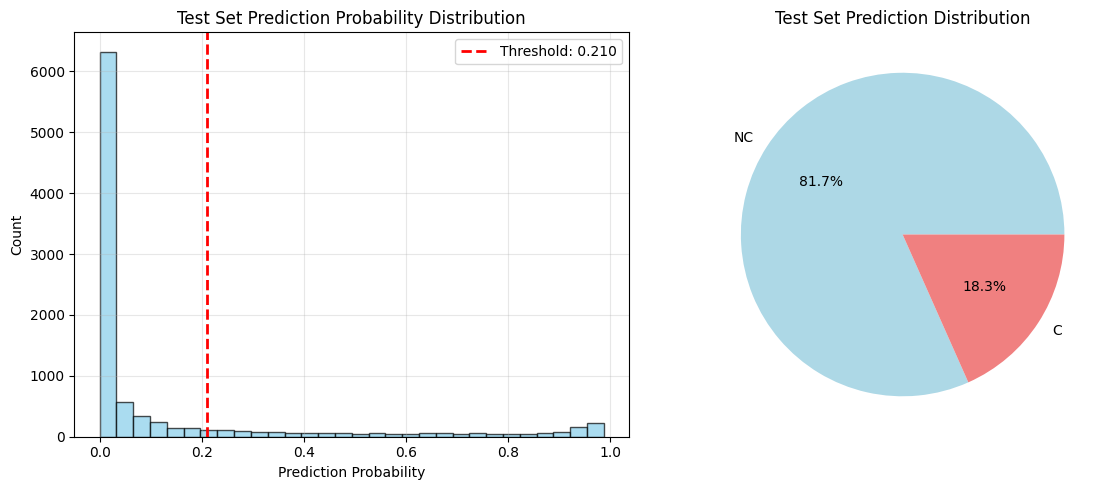


📋 Output Format Verification:
Required columns: ['file_name', 'Cold']
Actual columns: ['file_name', 'Cold']
Column types: file_name    object
Cold         object
dtype: object
Unique labels: ['C' 'NC']
Sample rows:
       file_name Cold
0  test_0001.wav    C
1  test_0002.wav    C
2  test_0003.wav   NC
3  test_0004.wav   NC
4  test_0005.wav   NC


In [17]:
class TestDataset(Dataset):
    def __init__(self, embedding_dict: dict):
 
        self.samples = []
        
        for file_id, emb in embedding_dict.items():
            sample = (
                file_id,
                torch.tensor(emb, dtype=torch.float32)
            )
            self.samples.append(sample)
        
        print(f"✅ Test dataset created with {len(self.samples)} samples")
    
    def __getitem__(self, idx):
        file_id, embedding = self.samples[idx]
        return file_id, embedding
    
    def __len__(self):
        return len(self.samples)
    
    def get_filenames(self):
        return [sample[0] for sample in self.samples]

def load_test_embeddings(embedding_dir: str):
    npy_files = glob.glob(os.path.join(embedding_dir, "*.npy"))
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(load_single_acoustic_embedding, npy_files),
                            total=len(npy_files),
                            desc="Loading test embeddings"))
    
    embedding_dict = dict(results)
    print(f"✅ Loaded {len(embedding_dict)} test embeddings.")
    print(f"🧪 Sample shape: {next(iter(embedding_dict.values())).shape}")
    return embedding_dict

test_embedding_dir = "../embeddings/test_files" 
test_embeddings_dict = load_test_embeddings(test_embedding_dir)

test_dataset = TestDataset(test_embeddings_dict)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

predictions_dict = {}
probabilities_dict = {}

model.eval()
with torch.no_grad():
    with tqdm(total=len(test_loader.dataset),
              desc="Predicting on test data",
              unit="samples",
              ncols=100) as progress_bar:
        
        for batch_files, batch_X in test_loader:
            batch_X = batch_X.to(device)
            
            logits = model(batch_X).squeeze()
            probs = torch.sigmoid(logits)
            
            preds = (probs > best_t).long()
            
            for file_id, prob, pred in zip(batch_files, probs.cpu().numpy(), preds.cpu().numpy()):
                predictions_dict[file_id] = pred
                probabilities_dict[file_id] = prob
            
            progress_bar.update(batch_X.size(0))

import pandas as pd

results_df = pd.DataFrame({
    'file_name': list(predictions_dict.keys()),
    'Cold': [prob for prob in probabilities_dict.values()]  
})

results_df['Cold'] = results_df['file_name'].map(lambda x: 'C' if predictions_dict[x] == 1 else 'NC')

results_df['file_name'] = results_df['file_name'].apply(lambda x: f"{x}.wav" if not x.endswith('.wav') else x)

results_df.to_csv('test_predictions_emb.csv', index=False)

print(f"\n📊 Test Results Summary:")
print(f"   Total samples: {len(results_df)}")
print(f"   Predicted Healthy (NC): {(results_df['Cold'] == 'NC').sum()}")
print(f"   Predicted Cold (C): {(results_df['Cold'] == 'C').sum()}")
print(f"   Results saved to: test_predictions.csv")

print(f"\n📋 Sample Predictions:")
print(results_df.head(10))

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

probs_array = list(probabilities_dict.values())
ax1.hist(probs_array, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(best_t, color='red', linestyle='--', linewidth=2, label=f'Threshold: {best_t:.3f}')
ax1.set_title('Test Set Prediction Probability Distribution')
ax1.set_xlabel('Prediction Probability')
ax1.set_ylabel('Count')
ax1.legend()
ax1.grid(True, alpha=0.3)

pred_counts = results_df['Cold'].value_counts()
colors = ['lightblue' if label == 'NC' else 'lightcoral' for label in pred_counts.index]
ax2.pie(pred_counts.values, labels=pred_counts.index, autopct='%1.1f%%', colors=colors)
ax2.set_title('Test Set Prediction Distribution')

plt.tight_layout()
plt.savefig('test_predictions_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📋 Output Format Verification:")
print("Required columns: ['file_name', 'Cold']")
print(f"Actual columns: {list(results_df.columns)}")
print(f"Column types: {results_df.dtypes}")
print(f"Unique labels: {results_df['Cold'].unique()}")
print(f"Sample rows:")
print(results_df.head())